## Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as spio
import scipy.stats

from network_utils import (
    create_56bus,
    create_RX_from_net,
    calc_voltage_profile
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# hide top and right splines on plots
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
time_ticks =  [0      ,    2400,    4800,    7200,    9600,   12000,   14400]
time_labels = ['0h', '4h', '8h', '12h', '16h', '20h', '24h']
# time_labels = ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00', '24:00']

vmin = 11.4  # kV
vmax = 12.6

## Load data

In [4]:
# load the mat files
actual_solar = spio.loadmat('data/PV.mat', squeeze_me=True)
actual_p = spio.loadmat('data/aggr_p.mat', squeeze_me=True)
actual_q = spio.loadmat('data/aggr_q.mat', squeeze_me=True)
pq_fluc = spio.loadmat('data/pq_fluc.mat', squeeze_me=True)

# for mat in [actual_solar, actual_p, actual_q, pq_fluc]:
#     display(mat)

# all of the `.mat` files have only 1 key each
actual_solar = actual_solar['actual_PV_profile']  # shape [14421]
actual_p = actual_p['p']  # shape [14421]
actual_q = actual_q['q']  # shape [14421]
pq_fluc = pq_fluc['pq_fluc']  # shape [55, 2, 14421]

In [5]:
# for reference: there are 14,400 seconds in a 24-hour period
for x in [actual_solar, actual_p, actual_q, pq_fluc]:
    print(x.dtype, x.shape)

float64 (14421,)
float64 (14421,)
float64 (14421,)
float64 (55, 2, 14421)


## Explore aggregated data

In [6]:
df = pd.DataFrame({'solar': actual_solar, 'p': actual_p, 'q': actual_q})
df.describe()

,solar,p,q
count,14421.000000,14421.000000,14421.000000
mean,4.034735,4.906571,2.141287
std,5.233045,1.351364,0.592001
min,0.000000,2.445197,1.067403
25%,0.000000,3.851689,1.670112
50%,0.016979,5.301955,2.311472
75%,9.340366,6.034900,2.636189
max,13.393226,7.139390,3.120953


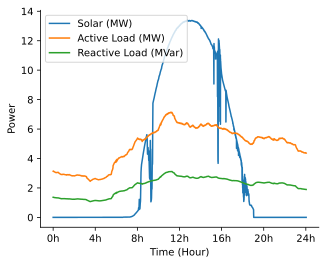

In [7]:
# Recreate Fig7 from Qu and Li (2020), equivalent to Fig5 (left) from  Shi et al. (2021)
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(actual_solar, label = 'Solar (MW)')  # TODO: what are the units?
ax.plot(actual_p, label = 'Active Load (MW)')
ax.plot(actual_q, label = 'Reactive Load (MVar)')

ax.legend(loc = 'upper left')
ax.set(xlabel='Time (Hour)', ylabel='Power')
ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels)
plt.show()

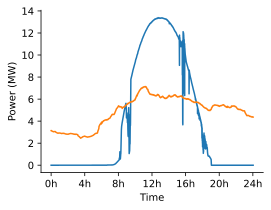

In [8]:
# Recreate Fig7 from Qu and Li (2020), equivalent to Fig5 (left) from  Shi et al. (2021)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(actual_solar, label = 'Solar (MW)')  # TODO: what are the units?
ax.plot(actual_p, label = 'Active Load (MW)')

ax.set(xlabel='Time', ylabel='Power (MW)')
ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels)
plt.show()

## Explore per-bus data

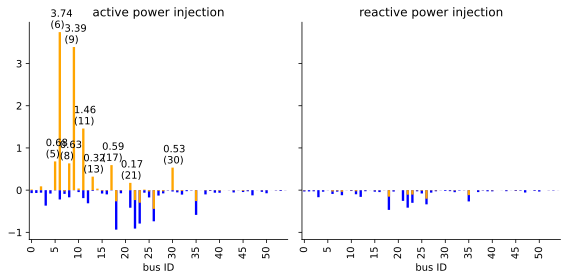

In [9]:
all_p = pq_fluc[:, 0]  # shape [n, T]
all_q = pq_fluc[:, 1]  # shape [n, T]

p_df = pd.DataFrame(all_p.T)  # rows = time, cols = buses
q_df = pd.DataFrame(all_q.T)

min_p = p_df.min()
max_p = p_df.max()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
ax = axs[0]
ax.set_title('active power injection')
min_p.plot(kind='bar', ax=ax, color='blue')
max_p.plot(kind='bar', ax=ax, color='orange')

for i in max_p.index:
    val = max_p.loc[i]
    if val > 0.1:
        ax.annotate(f'{val:.2f}\n({i})', (i - 2, val + 0.1))

ax = axs[1]
ax.set_title('reactive power injection')
q_df.min().plot(kind='bar', ax=ax, color='blue')
q_df.max().plot(kind='bar', ax=ax, color='orange')

for ax in axs:
    ax.set_xticks(range(0, 55, 5))
    ax.set(xlabel='bus ID')

plt.show()

Plot buses whose active power injections are most and least correlated with solar

10    1.000000
6     0.999991
18    0.999988
7     0.999746
14    0.999598
Name: corr, dtype: float64

38   -0.900397
40   -0.912778
51   -0.935417
26   -0.938779
20   -0.955161
Name: corr, dtype: float64

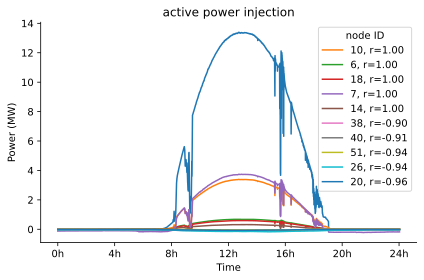

In [10]:
pv_corr = pd.Series(
    data=[scipy.stats.pearsonr(p, actual_solar)[0] for p in all_p],
    name='corr')
pv_corr.sort_values(ascending=False, inplace=True)
pv_corr.index += 1
display(pv_corr.head())
display(pv_corr.tail())

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(actual_solar)
for i in pv_corr.index[:5]:
    ax.plot(all_p[i-1], label=f'{i}, r={pv_corr.loc[i]:.2f}')
for i in pv_corr.index[-5:]:
    ax.plot(all_p[i-1], label=f'{i}, r={pv_corr.loc[i]:.2f}')
ax.legend(title='node ID')
ax.set(xlabel='Time', ylabel='Power (MW)', title='active power injection')
ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels)
plt.show()

In [11]:
pv_nodes_gq = np.array([2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 23, 25, 26, 32])
pv_corr.loc[pv_nodes_gq - 1]

1     0.859392
3     0.963687
6     0.999991
7     0.999746
8     0.568665
9     0.995374
10    1.000000
11    0.972255
12    0.997873
13   -0.511220
14    0.999598
15    0.996589
18    0.999988
19    0.492897
22    0.264856
24   -0.554543
25    0.718197
31    0.999154
Name: corr, dtype: float64

In [12]:
net = create_56bus()
R, X = create_RX_from_net(net)
v_sq = calc_voltage_profile(X, R, p=all_p, qe=all_q, qc=0, v_sub=12**2)
v = np.sqrt(v_sq)

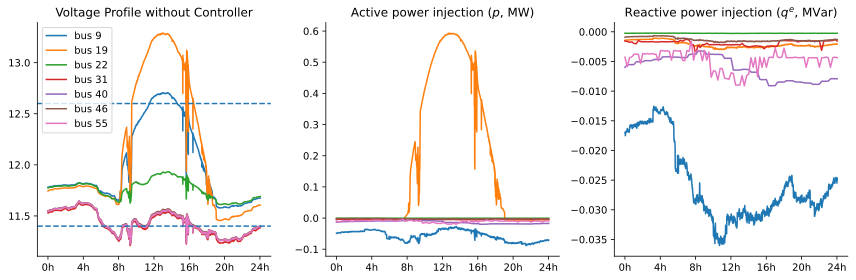

In [13]:
# Recreate Fig8 (right) in Qu and Li (2020)
# - they count the substation as bus 1
# - we count the substation as bus -1
index = [9, 19, 22, 31, 40, 46, 55]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

for i in np.asarray(index) - 2:
    axs[0].plot(v[i], label=f'bus {i+2}')
    axs[1].plot(all_p[i])
    axs[2].plot(all_q[i])

for ax in axs:
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)

ax = axs[0]
ax.axhline(vmin, ls='--')
ax.axhline(vmax, ls='--')
ax.legend()
ax.set_title('Voltage Profile without Controller')

axs[1].set_title('Active power injection ($p$, MW)')
axs[2].set_title('Reactive power injection ($q^e$, MVar)')

plt.show()

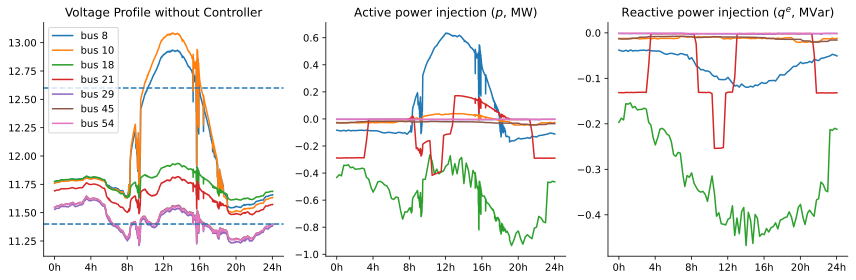

In [14]:
# Recreate Fig5 (middle) in Shi et al. (2021)
# - like us, they count the substation as bus -1
index = [8, 10, 18, 21, 29, 45, 54]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

for i in np.asarray(index):
    axs[0].plot(v[i], label=f'bus {i}')
    axs[1].plot(all_p[i])
    axs[2].plot(all_q[i])

for ax in axs:
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)

ax = axs[0]
ax.axhline(vmin, ls='--')
ax.axhline(vmax, ls='--')
ax.legend()
ax.set_title('Voltage Profile without Controller')

axs[1].set_title('Active power injection ($p$, MW)')
axs[2].set_title('Reactive power injection ($q^e$, MVar)')

plt.show()

Plot nodes with largest violations above and below the limits

In [15]:
pos_maxviolate_node = v.max(axis=1).argmax()
neg_maxviolate_node = v.min(axis=1).argmin()
print(f'Node: {pos_maxviolate_node}, Voltage: {v[pos_maxviolate_node].max()}')
print(f'Node: {neg_maxviolate_node}, Voltage: {v[neg_maxviolate_node].min()}')

Node: 17, Voltage: 13.288860940695322
Node: 35, Voltage: 11.09995582894366


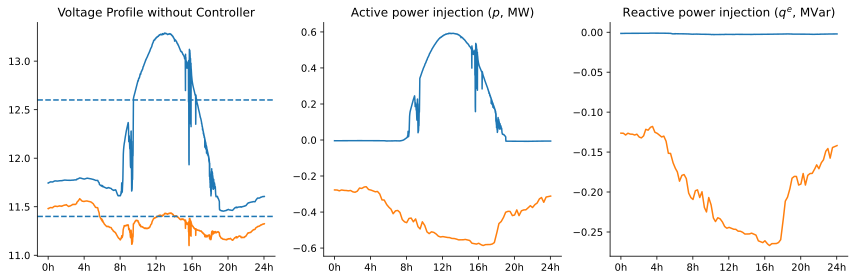

In [16]:
index = [17, 35]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

for i in np.asarray(index):
    axs[0].plot(v[i])
    axs[1].plot(all_p[i])
    axs[2].plot(all_q[i])

for ax in axs:
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)

ax = axs[0]
ax.axhline(vmin, ls='--')
ax.axhline(vmax, ls='--')
ax.set_title('Voltage Profile without Controller')

axs[1].set_title('Active power injection ($p$, MW)')
axs[2].set_title('Reactive power injection ($q^e$, MVar)')

plt.show()